In [1]:
import numpy as np
import sparrowpy as sp
from sparrowpy import image_source as ims


import pyfar as pf
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\heimes\AppData\Local\miniconda3\envs\sparrowpy\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\heimes\AppData\Local\miniconda3\envs\sparrowpy\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\heimes\AppData\Local\miniconda3\envs\sparrowpy\Lib\site-packages\ipykernel\kernelapp.py

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

fast rad

In [2]:
# Define parameters
X = 3
Y = 3
Z = 3
patch_size = 1
ir_length_s = 2
sampling_rate = 1000
max_order_k = 5
speed_of_sound = 346.18
absorption = 0.1

# create geometry
walls = sp.testing.shoebox_room_stub(X, Y, Z)
source_pos = [0.5, 0.5, 0.5]
source = sp.geometry.SoundSource(source_pos, [0, 1, 0], [0, 0, 1])
receiver_pos = [0.25, 0.25, 0.25]


# create object
radiosity_fast = sp.DRadiosityFast.from_polygon(walls, patch_size)

# create directional scattering data (totally diffuse)
sources = pf.samplings.sph_gaussian(sh_order=5)
sources = sources[sources.z>=0]
print(f'number of sources {sources.csize}')
receivers = pf.samplings.sph_gaussian(sh_order=5)
receivers = receivers[receivers.z>=0]
print(f'number of receivers {receivers.csize}')
frequencies = np.array([500])
data_scattering = sp.brdf.create_from_scattering(
    sources, receivers,
    pf.FrequencyData(np.zeros_like(frequencies), frequencies))

# set directional scattering data
radiosity_fast.set_wall_scattering(
    np.arange(len(walls)), data_scattering, sources, receivers)

# set air absorption
radiosity_fast.set_air_attenuation(
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies),
        data_scattering.frequencies))

# set absorption coefficient
radiosity_fast.set_wall_absorption(
    np.arange(len(walls)),
    pf.FrequencyData(
        np.zeros_like(data_scattering.frequencies)+absorption,
        data_scattering.frequencies))


number of sources 36
number of receivers 36


C:\Users\heimes\AppData\Local\Temp\ipykernel_67224\3685337642.py:23: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  sources = pf.samplings.sph_gaussian(sh_order=5)
c:\Users\heimes\AppData\Local\miniconda3\envs\sparrowpy\Lib\site-packages\pyfar\samplings\samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
c:\Users\heimes\AppData\Local\miniconda3\envs\sparrowpy\Lib\site-packages\pyfar\classes\coordinates.py:265: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order
C:\Users\heimes\AppData\Local\Temp\ipykernel_67224\3685337642.py:26: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  receivers = pf.samplings.sph_gaussian(sh_order=5)
C:\Users\heimes\AppData\Local\Temp\ipykernel

In [3]:
# calculate from factors including directivity and absorption
start = datetime.now()
radiosity_fast.bake_geometry(algorithm='order')
delta = (datetime.now() - start)
print(f"Time elapsed for bake_geometry: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

D:\git\_pyfar\sparapy\sparrowpy\radiosity_fast\form_factor.py:198: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  form_factors[i,j] = calc_form_factor(


Time elapsed for bake_geometry: 0:01:06.029665


In [ ]:
# initialize source energy at each patch
start = datetime.now()
radiosity_fast.init_source_energy(source_pos, algorithm='order')
delta = (datetime.now() - start)
print(f"Time elapsed for init_source_energy: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6


# calculate energy exchange
start = datetime.now()
radiosity_fast.calculate_energy_exchange(
    speed_of_sound=speed_of_sound,
    histogram_time_resolution=1/sampling_rate,
    histogram_length=ir_length_s,
    algorithm='order', max_depth=max_order_k)

# gather energy at receiver
ir_fast = radiosity_fast.collect_receiver_energy(
    receiver_pos,
    )
reverberation_fast = pf.Signal(ir_fast[0, 0, 0], sampling_rate=sampling_rate)
delta = (datetime.now() - start)
print(f"Time elapsed for calculate_energy_exchange_receiver: {delta}")
fast_time_s = (delta.seconds*1e6 + delta.microseconds)/1e6

Time elapsed for init_source_energy: 0:00:08.293791
Time elapsed for calculate_energy_exchange_receiver: 0:00:09.559629


In [9]:
reverberation_fast = pf.Signal(ir_fast[0, 0, 0], sampling_rate=sampling_rate)


image source

In [10]:
MaxOrder = 5


RoomSizes = (3, 3, 3)
WallsHesse = ims.get_walls_hesse(*RoomSizes)


WallsR = 0.9
SourcePos = [0.50, 0.50, 0.50]


ISList_valid = ims.calculate_image_sources(WallsHesse, SourcePos, MaxOrder)


ReceiverPos = [0.25, 0.25, 0.25]
ISList_audible = ims.filter_image_sources(ISList_valid, WallsHesse, ReceiverPos)


impulse_response = ims.calculate_impulse_response(ISList_audible, WallsR, ReceiverPos)
energy = np.square(impulse_response)
image_source = pf.Signal(energy, 10000)


compare

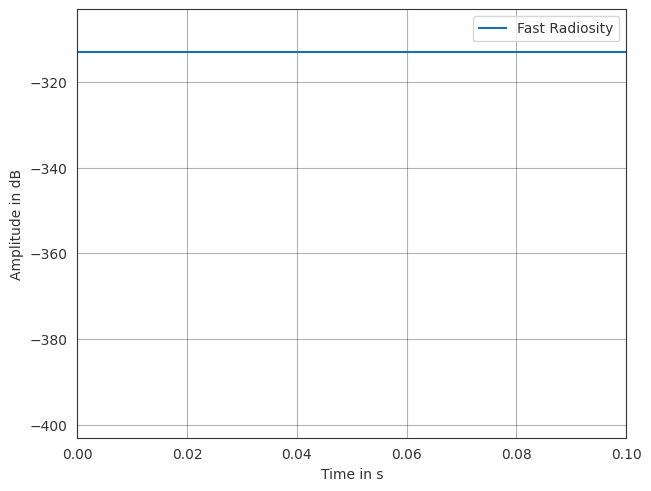

In [12]:
pf.plot.use()
plt.figure()

# ax = pf.plot.time(image_source, dB=True, label="Image Source Method")
ax = pf.plot.time(reverberation_fast, dB=True, label="Fast Radiosity")

#title = title = f"Radiosity Order {k} Patch Size {patch_size} vs Image Source Order {MaxOrder}"
ax.legend(loc="upper right")
ax.set_xlim([0, 0.1])
#plt.title(title)
plt.show()